In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
from sqlalchemy import create_engine, MetaData, Table
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# Reflect an existing database into a new model
metadata = MetaData()
metadata.reflect(bind=engine)

# reflect the tables
print(metadata.tables.keys())

dict_keys(['measurement', 'station'])


In [6]:
# View all of the classes that automap found
Base = automap_base(metadata=metadata)
Base.prepare(engine, reflect=True)
Base.classes.keys()


/var/folders/qq/qrfkk9w160926bggf7wq3ws80000gn/T/ipykernel_15483/1555385933.py:3: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


['station', 'measurement']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station


In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Precipitation Analysis

In [9]:
import datetime as dt

# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date 


('2017-08-23',)

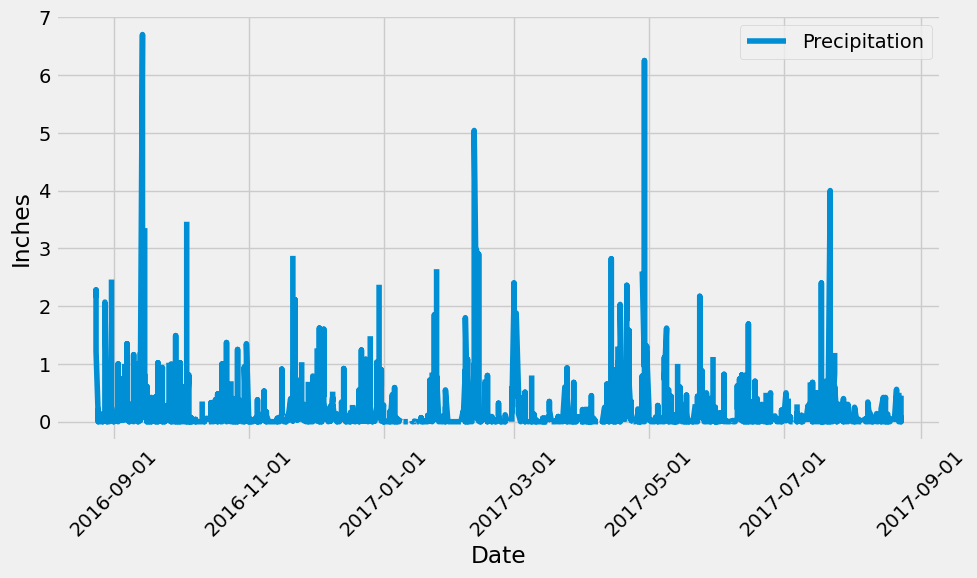

In [10]:

# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.

one_year_ago = dt.datetime.strptime(most_recent_date[0], '%Y-%m-%d') - dt.timedelta(days=365)
one_year_ago


# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago).all()


# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(results, columns=['date', 'prcp'])

# Sort the dataframe by date
df = df.sort_values('date')

df['date'] = pd.to_datetime(df['date'])

df_filtered = df[(df['date'] >= one_year_ago) & (df['date'] <= df['date'].max())]
df_filtered.head()


# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10,6))
plt.plot(df_filtered['date'], df['prcp'])
plt.xlabel('Date')
plt.ylabel('Inches')
plt.legend(['Precipitation'])
plt.grid(True)
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1, interval=2))  # to display date in every 2 months
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.tight_layout()
plt.show()


In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
df['date'] = df['date'].dt.strftime('%Y-%m-%d')
df.describe()


,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(Station).count()
total_stations


9

In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
query = """
SELECT station, COUNT(*) as count
FROM measurement
GROUP BY station
ORDER BY count DESC
"""

most_active_stations = pd.read_sql(query, engine)
most_active_stations

,station,count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = most_active_stations['station'][0]
query = f"""
SELECT MIN(tobs) as min_temp, MAX(tobs) as max_temp, AVG(tobs) as avg_temp
FROM measurement
WHERE station = '{most_active_station}'
"""

most_active_station_temps = pd.read_sql(query, engine)
most_active_station_temps

,min_temp,max_temp,avg_temp
0,54.0,85.0,71.663781


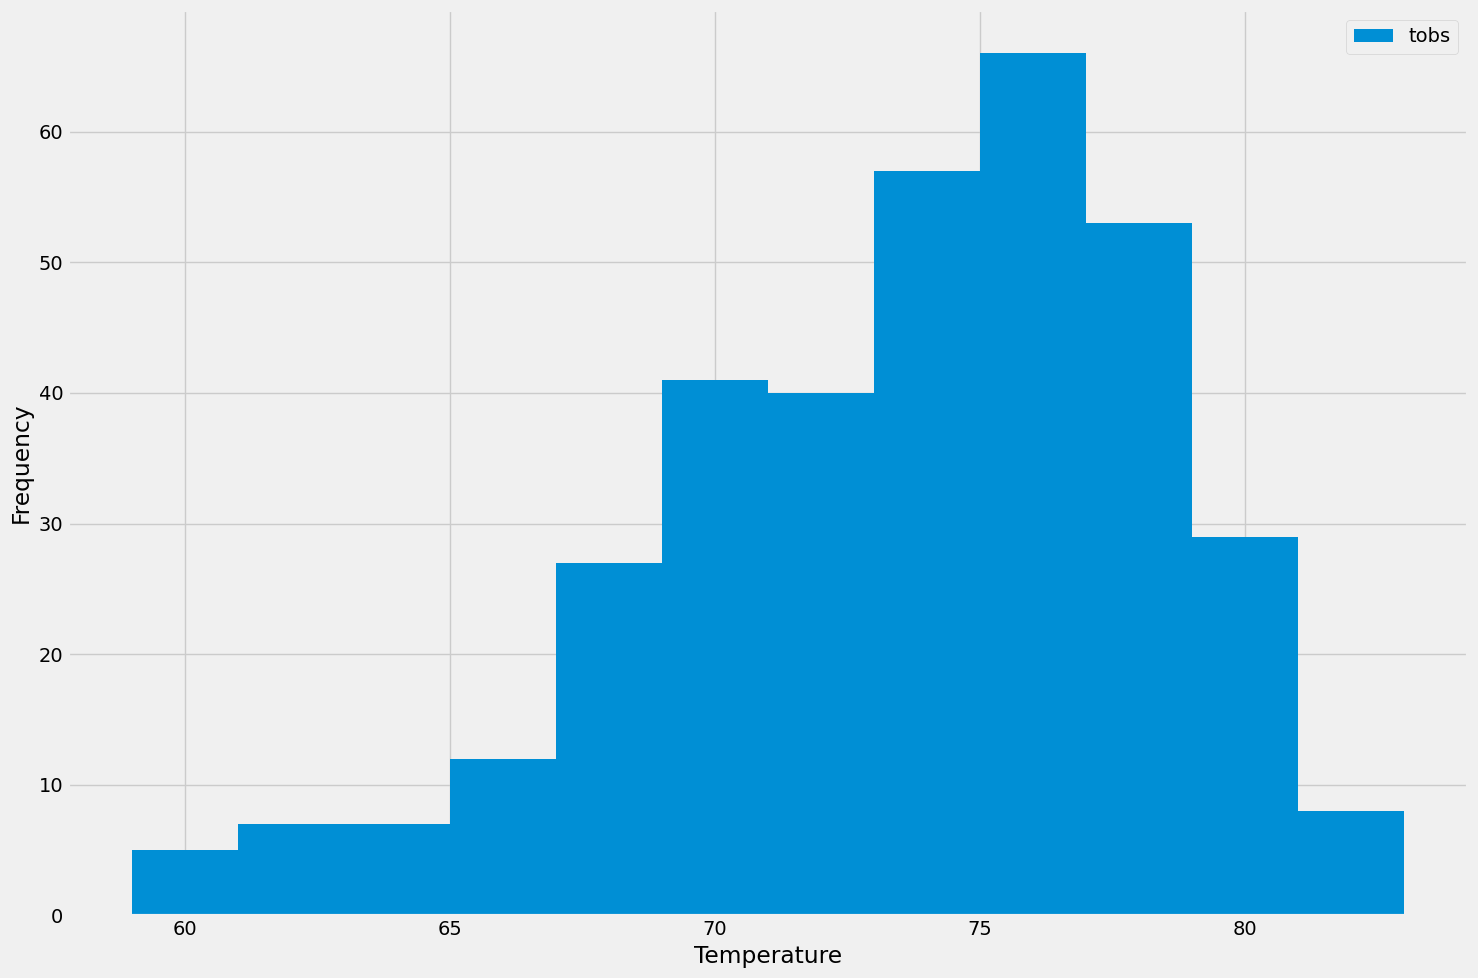

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
query = f"""
SELECT tobs
FROM measurement
WHERE station = '{most_active_station}'
AND date >= '{one_year_ago.strftime('%Y-%m-%d')}'
"""

most_active_station_temps = pd.read_sql(query, engine)

plt.figure(figsize=(15,10))
plt.hist(most_active_station_temps['tobs'], bins=12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend(['tobs'])
plt.tight_layout()
plt.show()



# Close Session

In [16]:
# Close Session
session.close()